In [69]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.optimize import basinhopping
from pyswarm import pso
from scipy.optimize import minimize
from scipy.optimize import curve_fit
import pandas as pd

eps = 0.001

from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
rcParams["figure.dpi"] = 100
img_dir = "./images/"

In [70]:
def generate_data(k=1000):
    X = np.array([3*i/1000 for i in range(k)])
    
    f = lambda x: 1/(x**2-3*x+2)
    f_x = map(f, X)
    
    Y = np.zeros(k)
    for i, f_val in enumerate(f_x):
        if abs(f_val) > 100:
            Y[i] = np.sign(f_val)*100 + np.random.normal(0, 1)
        else:
            Y[i] = f_val + np.random.normal(0, 1)
            
    return X, Y

def minim_poly(x, a, b, c, d):
    return (a*x + b) / (x**2 + c*x + d)

def minim_poly_lm(x, params):
    a = params['a'].value
    b = params['b'].value
    c = params['c'].value
    d = params['d'].value
    return (a*x + b) / (x**2 + c*x + d)

def mse_loss(params, Y, X, func):
    # print(params)
    mse = np.mean((func(X, *params) - Y)**2)
    return mse

def mse_loss_lm(params, Y, X, func):
    # a = params['a'].value
    # b = params['b'].value
    # c = params['c'].value
    # d = params['d'].value
    # sum_ = 0
    #for x, y in zip(X, Y):
    mse = np.mean((func(X, params) - Y) ** 2)
    return [mse]

# Simulated Annealing

In [71]:
X, Y = generate_data()
init_guess = np.random.uniform(size = 4)

%time anneal_res = basinhopping(mse_loss, init_guess, T=0.5, minimizer_kwargs={"args": (Y, X, minim_poly)}, niter=1000, niter_success=200)
print(anneal_res)

CPU times: user 13.7 s, sys: 19.9 ms, total: 13.7 s
Wall time: 13.9 s
                        fun: 136.06163876726913
 lowest_optimization_result:       fun: 136.06163876726913
 hess_inv: array([[ 8.16620941e-03, -8.16898978e-03, -3.54955244e-06,
         3.26514692e-06],
       [-8.16898978e-03,  8.17186877e-03,  3.36383798e-06,
        -3.07923623e-06],
       [-3.54955276e-06,  3.36383830e-06,  7.69248352e-07,
        -7.69557183e-07],
       [ 3.26514724e-06, -3.07923655e-06, -7.69557183e-07,
         7.69883705e-07]])
      jac: array([ -1.18363571,  -1.18059158, 835.73763657, 835.52537537])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 857
      nit: 32
     njev: 141
   status: 2
  success: False
        x: array([-1.00060378,  1.00107751, -2.00094035,  1.00095642])
                    message: ['success condition satisfied']
      minimization_failures: 228
                       nfev: 208167
                        nit: 238
             

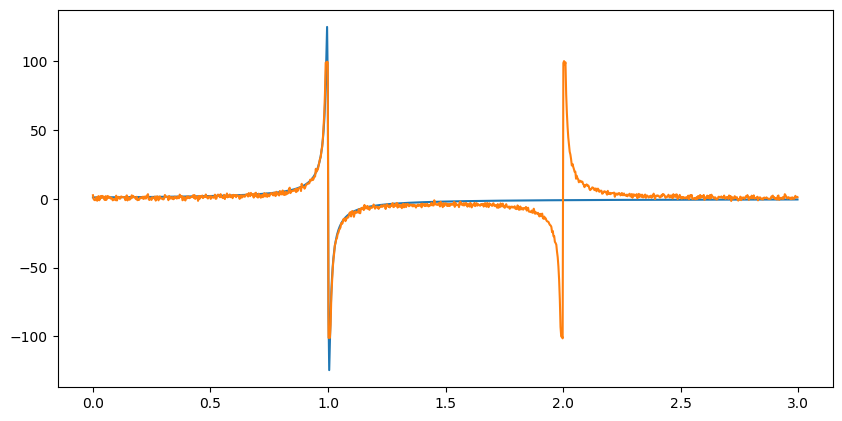

In [72]:
plt.plot(X, minim_poly(X, *anneal_res.x) )
_ = plt.plot(X, Y)

# Swarm optimization

In [73]:
%time swarm_xopt, swarm_fopt = pso(mse_loss, [-4]*4, [4]*4, args=(Y, X, minim_poly), swarmsize=100, omega=0.7, phip=0.5, phig=0.5, maxiter=1000, minstep=1e-8, minfunc=1e-8, debug=False)
print(f"Found minimum {swarm_fopt} at {swarm_xopt}")

Stopping search: maximum iterations reached --> 1000
CPU times: user 8.68 s, sys: 7.85 ms, total: 8.69 s
Wall time: 8.78 s
Found minimum 154.8880250698341 at [-1.07384249  1.07617632 -2.00799598  1.00804652]


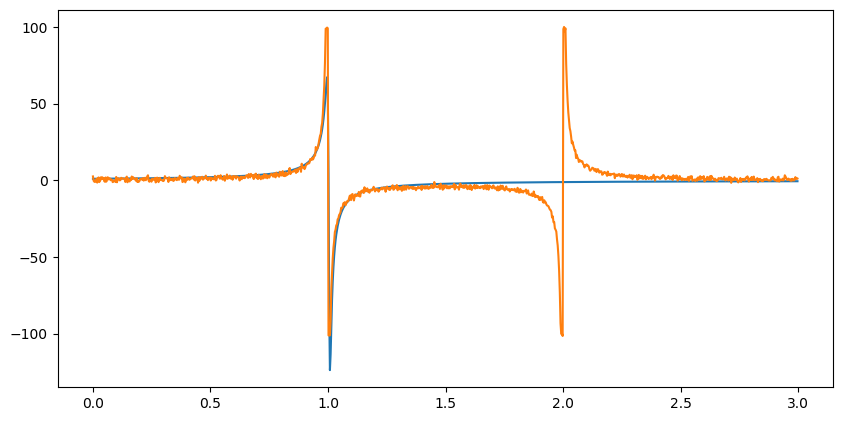

In [74]:
plt.plot(X, minim_poly(X, *swarm_xopt) )
_ = plt.plot(X, Y)

# Nelder-Mead

In [75]:
%time NM_res = minimize(mse_loss, init_guess, args=(Y, X, minim_poly), method="Nelder-Mead", tol=eps, options={"maxiter":1000, "adaptive":True})
print(NM_res)

CPU times: user 70.3 ms, sys: 13 µs, total: 70.4 ms
Wall time: 73.8 ms
 final_simplex: (array([[ 0.0372853 , -0.04091422, -2.02301226,  1.02317468],
       [ 0.03726163, -0.04090048, -2.02305012,  1.02321287],
       [ 0.03719674, -0.04087404, -2.02308941,  1.02325334],
       [ 0.03723512, -0.04090341, -2.02298904,  1.02315128],
       [ 0.03713374, -0.04085109, -2.02311191,  1.02327651]]), array([239.1412538 , 239.14129148, 239.14147777, 239.14179774,
       239.14222133]))
           fun: 239.1412538044206
       message: 'Optimization terminated successfully.'
          nfev: 673
           nit: 388
        status: 0
       success: True
             x: array([ 0.0372853 , -0.04091422, -2.02301226,  1.02317468])


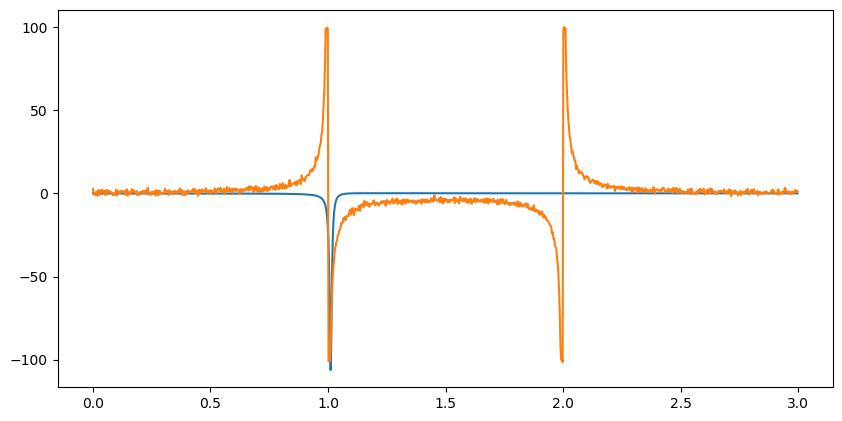

In [76]:
plt.plot(X, minim_poly(X, *NM_res.x) )
_ = plt.plot(X, Y)

# Levenberg-Marquardt

In [77]:
# param = Parameters()
# rand_float = np.random.uniform
# param.add('a', value=rand_float(), min=-5, max=5)
# param.add('b', value=rand_float(), min=-5, max=5)
# param.add('c', value=rand_float(), min=-5, max=5)
# param.add('d', value=rand_float(), min=-5, max=5)

# LM_res = lm_min(mse_loss_lm, param, args=(Y, X, minim_poly_lm))
#LM_koeffs = [LM_res.params["a"].value, LM_res.params["b"].value, LM_res.params["c"].value, LM_res.params["d"].value]

# leastsq(mse_loss, init_guess, args=(Y, X, minim_poly))
%time LM_koeffs = curve_fit(minim_poly, X, Y, method="lm")
print(LM_koeffs)

CPU times: user 9.05 ms, sys: 0 ns, total: 9.05 ms
Wall time: 8 ms
(array([-1.00354933,  1.00400395, -2.00086079,  1.00087693]), array([[ 2.03578843e-03, -2.03648784e-03, -9.93442448e-07,
         9.31919652e-07],
       [-2.03648784e-03,  2.03722437e-03,  9.15914994e-07,
        -8.54382065e-07],
       [-9.93442449e-07,  9.15914995e-07,  3.01136670e-07,
        -3.01053750e-07],
       [ 9.31919653e-07, -8.54382066e-07, -3.01053750e-07,
         3.00974643e-07]]))


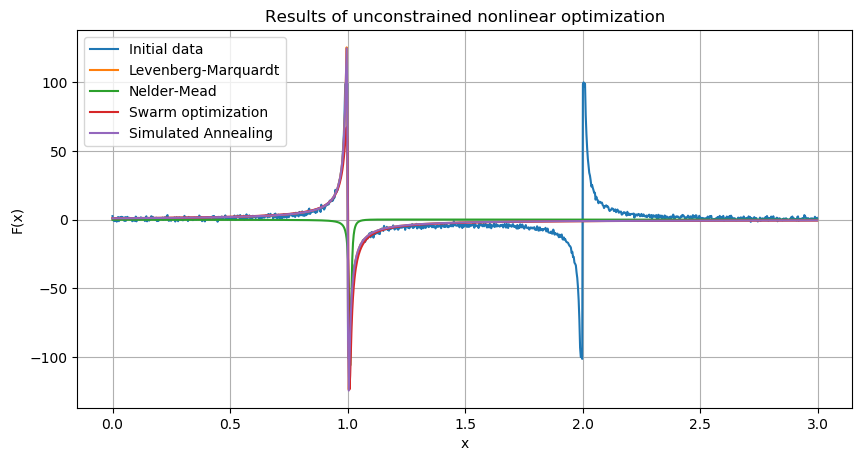

In [78]:
# x_data = algos_time.n
fig, ax = plt.subplots()
plt.grid()

# plt.ylim(0, 12.5)
# plt.xlim(0, 2000)

ax.set_xlabel("x")
ax.set_ylabel("F(x)")
ax.set_title(f"Results of unconstrained nonlinear optimization")

plt.plot(X, Y, label="Initial data")

# popt, pcov = curve_fit(const_line, x_data, algos_time.const*10**6)
# params = [ '%.2E' % Decimal(p) for p in popt ]

# plt.plot(x_data, const_line(x_data, *popt), 'r-',  linewidth=2,
#          label=f'Constant approximation: a={params[0]}') #% tuple(params))

plt.plot(X, minim_poly(X, *LM_koeffs[0]), label="Levenberg-Marquardt" )
plt.plot(X, minim_poly(X, *NM_res.x), label="Nelder-Mead" )
plt.plot(X, minim_poly(X, *swarm_xopt), label="Swarm optimization" )
plt.plot(X, minim_poly(X, *anneal_res.x), label="Simulated Annealing" )

_ = plt.legend(loc="upper left")

plt.savefig(img_dir + "results.png")

In [79]:
# mse_loss(params, Y, X, func):
opt_keys = ["Simulated Annealing", "Swarm optimization", "Nelder-Mead", "Levenberg-Marquardt"]
opt_mse = [mse_loss(anneal_res.x, Y, X, minim_poly), mse_loss(swarm_xopt, Y, X, minim_poly), mse_loss(NM_res.x, Y, X, minim_poly), mse_loss(LM_koeffs[0], Y, X, minim_poly)]
n_iter = [61, 1000, 217, 44]
el_time = [16000, 4900, 65.2, 30.1]

opt_stats = pd.DataFrame(data={"Algorithm":opt_keys, "MSE": opt_mse, "# of iteration": n_iter, "Elapsed time, ms":el_time})

In [80]:
opt_stats = opt_stats.set_index("Algorithm")

In [81]:
opt_stats

,MSE,# of iteration,"Elapsed time, ms"
Algorithm,,,
Simulated Annealing,136.061639,61,16000.0
Swarm optimization,154.888025,1000,4900.0
Nelder-Mead,239.141254,217,65.2
Levenberg-Marquardt,136.065805,44,30.1
